# Self-Driving Car Engineer Nanodegree

## Step 0: Load The Data

In [10]:
import pickle
import csv
from prettytable import PrettyTable

#Load the Images and labels
training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#In memory load the mapping of label to text
label_mapping = [""]*43
with open('signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        label_mapping[int(row['ClassId'])] = row['SignName']
        
print("Data loading completed.")

Data loading completed.


---

## Step 1: Dataset Summary & Exploration



### Basic Summary of the Data Set

In [11]:
import numpy

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

n_train = len(X_train)

n_test = len(X_test)

n_valid = len(X_valid)

image_shape = X_train[0].shape

n_classes = numpy.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Numner of validation examples = ", n_valid)
print("Image data shape =", image_shape)

print("The loaded table is")
t = PrettyTable(['Class ID', 'Sign Name'])
for i in range(len(label_mapping)):
    t.add_row([i,label_mapping[i]])
    
print(t)


Number of training examples = 34799
Number of testing examples = 12630
Numner of validation examples =  4410
Image data shape = (32, 32, 3)
The loaded table is
+----------+----------------------------------------------------+
| Class ID |                     Sign Name                      |
+----------+----------------------------------------------------+
|    0     |                Speed limit (20km/h)                |
|    1     |                Speed limit (30km/h)                |
|    2     |                Speed limit (50km/h)                |
|    3     |                Speed limit (60km/h)                |
|    4     |                Speed limit (70km/h)                |
|    5     |                Speed limit (80km/h)                |
|    6     |            End of speed limit (80km/h)             |
|    7     |               Speed limit (100km/h)                |
|    8     |               Speed limit (120km/h)                |
|    9     |                     No passing     

###  Visualization of the images and labels

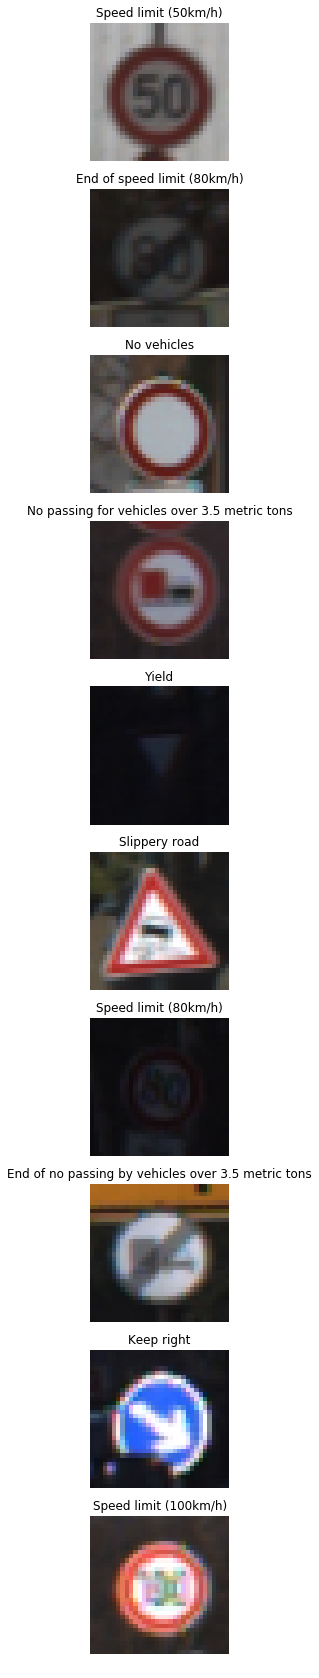

In [12]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

count = 10
fig, axs = plt.subplots(count, 1, figsize=(count, count*3))

for i in range(count):        
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(label_mapping[y_train[index]])



### Check count of each label

<Container object of 43 artists>

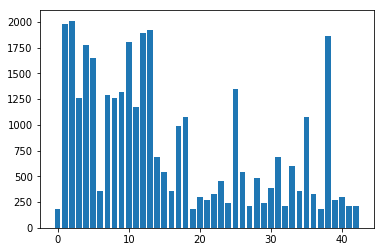

In [13]:
label_list = y_train.tolist()
label_count = [label_list.count(y) for y in range(n_classes)]

plt.bar(range(n_classes),label_count)

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set

#### Step 1) Reduce the training data gap between classes.

How to create more data for classes with low count?
I augment by shifting and roatating images.


#### Rotating an image

In [14]:
import scipy.ndimage

def rotate_image(image):
    image = scipy.ndimage.interpolation.rotate(image, random.randrange(-10, 10), reshape=False)
    return image


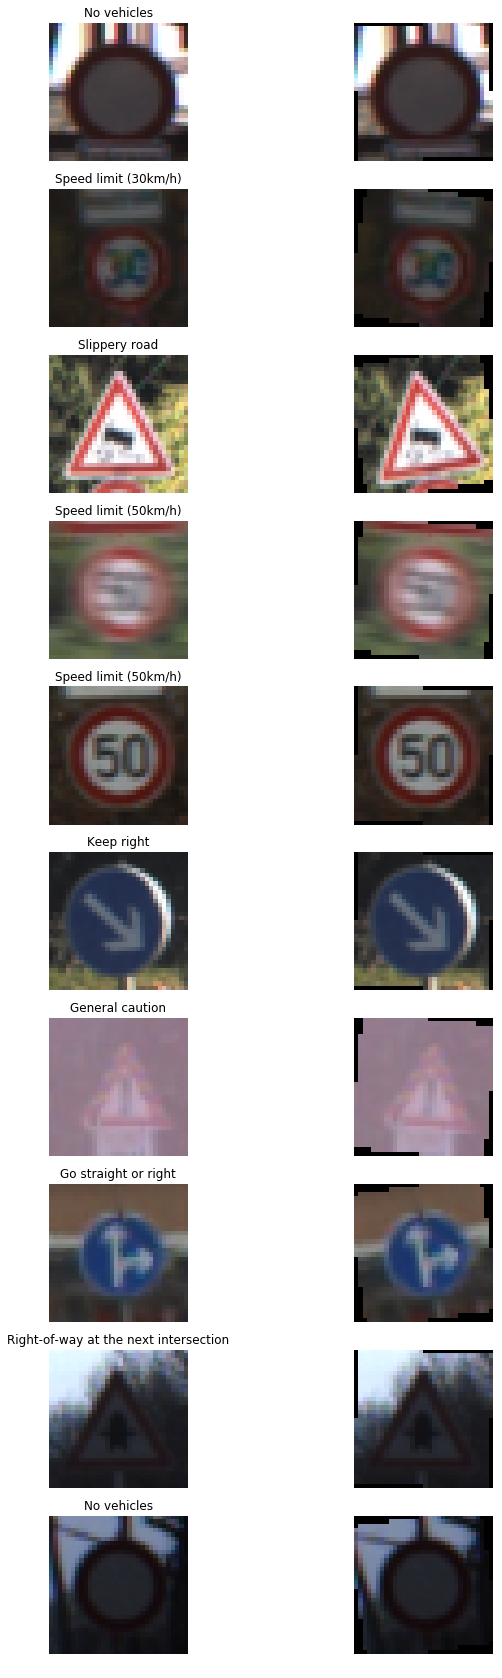

In [15]:
count = 10
fig, axs = plt.subplots(count, 2, figsize=(count, count*3))

for i in range(count):        
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i][0].imshow(image)
    axs[i][0].axis('off')
    axs[i][0].set_title(label_mapping[y_train[index]])
    
    axs[i][1].imshow(rotate_image(image))
    axs[i][1].axis('off')
    


#### Shifting an image

In [16]:
import scipy.ndimage

def shift_image(image):
    image = scipy.ndimage.interpolation.shift(image, [random.randrange(-2, 2), random.randrange(-2, 2), 0])
    return image


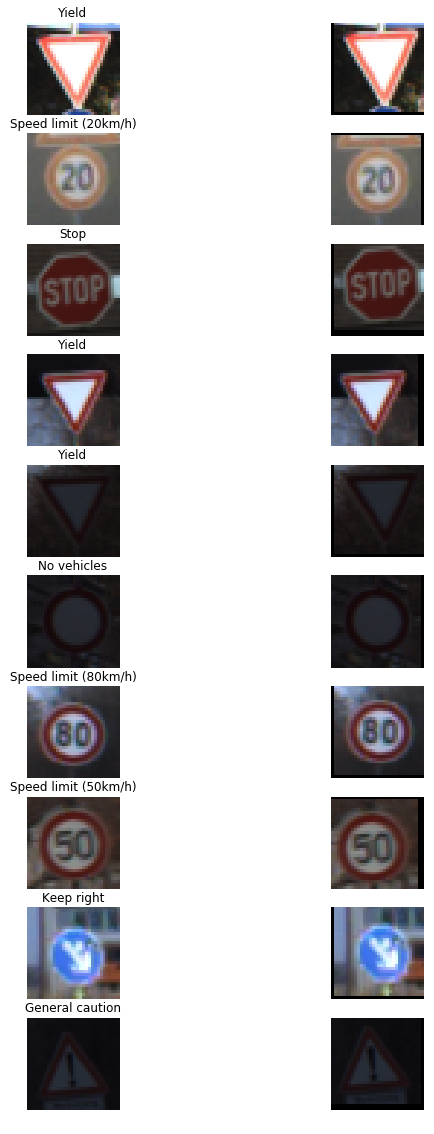

In [17]:
count = 10
fig, axs = plt.subplots(count, 2, figsize=(count, count*2))

for i in range(count):        
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i][0].imshow(image)
    axs[i][0].axis('off')
    axs[i][0].set_title(label_mapping[y_train[index]])
    
    axs[i][1].imshow(shift_image(image))
    axs[i][1].axis('off')
    


#### Augment the data that occured less

In [18]:
import scipy.ndimage

def create_variant(image):
    if (random.choice([True, False])):
        image = rotate_image(image)
    else:
        image = shift_image(image)
    return image


In [21]:
import math

sample_per_class = 2000

for i in range(n_classes):
    multiplier = math.floor(sample_per_class/label_count[i])
    print("Class {} occuring {} times should be augmented {} fold".format(i,label_count[i],multiplier))

Class 0 occuring 180 times should be augmented 11 fold
Class 1 occuring 1980 times should be augmented 1 fold
Class 2 occuring 2010 times should be augmented 0 fold
Class 3 occuring 1260 times should be augmented 1 fold
Class 4 occuring 1770 times should be augmented 1 fold
Class 5 occuring 1650 times should be augmented 1 fold
Class 6 occuring 360 times should be augmented 5 fold
Class 7 occuring 1290 times should be augmented 1 fold
Class 8 occuring 1260 times should be augmented 1 fold
Class 9 occuring 1320 times should be augmented 1 fold
Class 10 occuring 1800 times should be augmented 1 fold
Class 11 occuring 1170 times should be augmented 1 fold
Class 12 occuring 1890 times should be augmented 1 fold
Class 13 occuring 1920 times should be augmented 1 fold
Class 14 occuring 690 times should be augmented 2 fold
Class 15 occuring 540 times should be augmented 3 fold
Class 16 occuring 360 times should be augmented 5 fold
Class 17 occuring 990 times should be augmented 2 fold
Class 1

#### I will now created augmented data and plot the new distribution

<Container object of 43 artists>

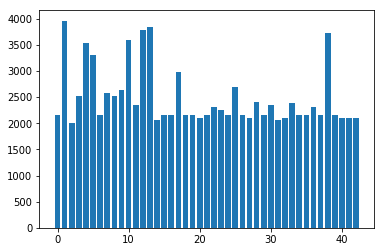

In [22]:
import math

augmented_image = []
augmented_labels = []

image_count = 0
for image, label in zip(X_train,y_train):    
    multiplier = math.floor(sample_per_class/label_count[label])
    image_count = image_count + 1
    augmented_image.append(image)
    augmented_labels.append(label)
    for i in range(multiplier):
        augmented_image.append(create_variant(image))
        augmented_labels.append(label)
        
augmented_list = (numpy.array(augmented_labels)).tolist()
augmented_count = [augmented_list.count(y) for y in range(n_classes)]

plt.bar(range(n_classes),augmented_count)
        

#### Step 2) Equalizing the images

Converting to b/w and then equalizing the image

In [23]:
from sklearn.utils import shuffle
from numpy import newaxis
import cv2
import numpy as np

def process_image(image):
    image_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_eq = cv2.equalizeHist(image_bw)
    return image_eq

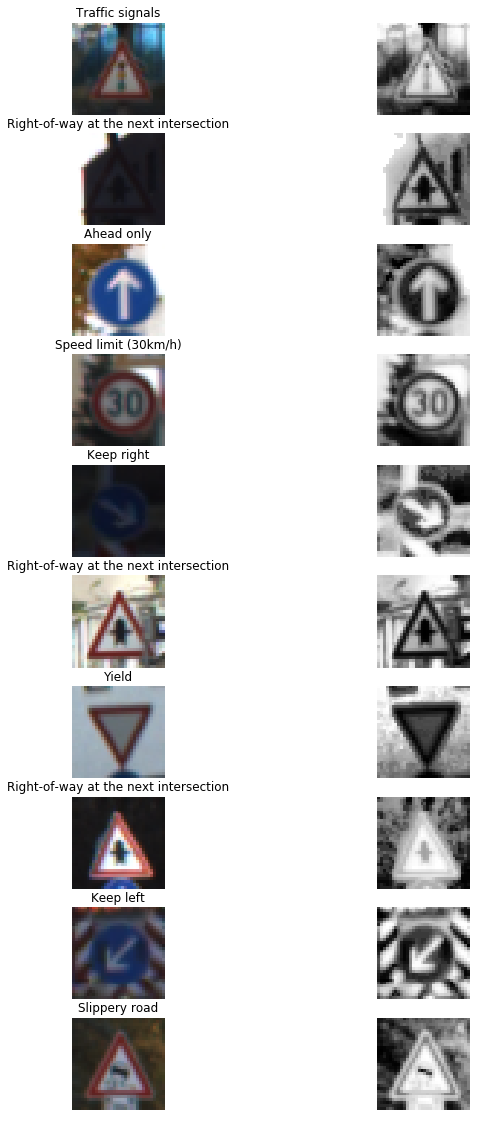

In [24]:
count = 10
fig, axs = plt.subplots(count, 2, figsize=(count, count*2))

for i in range(count):        
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i][0].imshow(image)
    axs[i][0].axis('off')
    axs[i][0].set_title(label_mapping[y_train[index]])
    axs[i][1].imshow(process_image(image), cmap='gray')
    axs[i][1].axis('off')
    


### Training

In [81]:
from sklearn.utils import shuffle
from numpy import newaxis
import cv2
import numpy as np

#Shuffle training data
X_train_shuffled, y_train_shuffled = shuffle(augmented_image, augmented_labels)

# preprocess
X_train_processed = numpy.array([process_image(image) for image in X_train_shuffled])
X_test_processed = numpy.array([process_image(image) for image in X_test])
X_valid_processed = numpy.array([process_image(image) for image in X_valid])

# reshape for conv layer
X_train_reshaped = X_train_processed[..., newaxis]
X_test_reshaped = X_test_processed[..., newaxis]
X_valid_reshaped = X_valid_processed[..., newaxis]

# normalize range
X_train_normalized = X_train_reshaped - np.mean(X_train_reshaped)
X_test_normalized = X_test_reshaped - np.mean(X_test_reshaped)
X_valid_normalized = X_valid_reshaped - np.mean(X_valid_reshaped)


### Model Architecture

In [31]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 15
BATCH_SIZE = 50

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    activation1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x12. Output = 14x14x12.
    pool1 = tf.nn.max_pool(activation1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,12,32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    activation2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x32. Output = 5x5x32.
    pool2 = tf.nn.max_pool(activation2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x32. Output = 800.
    flat_data = flatten(pool2)
#     flat_dropped_data = tf.nn.dropout(flat_data, 0.8)
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(flat_data, fc1_W) + fc1_b
    
    # Activation.
    activation2 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 200. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(activation2, fc2_W) + fc2_b
    
    # Activation.
    activation3 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    fc3   = tf.matmul(activation3, fc3_W) + fc3_b
    
    return fc3


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Features

In [32]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)


#### Training Pipeline

In [33]:
rate = 0.0008

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


#### Model Evaluation

In [34]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


#### Train the Model

In [35]:
import time
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        start_time = time.time()
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        valid_accuracy = evaluate(X_valid_normalized, y_valid)
        train_accuracy = evaluate(X_train_normalized, y_train_shuffled)
        print("EPOCH {}/{} ...".format(i+1,EPOCHS))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(valid_accuracy))
        print("Batch Size = {}".format(BATCH_SIZE))
        print("Time taken = {}".format(time.time()-start_time))
        print("Learning rate = {}".format(rate))
        print()
    
    print("\n\nNow running Testing")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Testing Accuracy = {:.3f}".format(test_accuracy))
    
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1/15 ...
Training Accuracy = 0.716
Validation Accuracy = 0.679
Batch Size = 50
Time taken = 31.45486307144165
Learning rate = 0.0008

EPOCH 2/15 ...
Training Accuracy = 0.867
Validation Accuracy = 0.806
Batch Size = 50
Time taken = 29.534165859222412
Learning rate = 0.0008

EPOCH 3/15 ...
Training Accuracy = 0.913
Validation Accuracy = 0.853
Batch Size = 50
Time taken = 30.22893190383911
Learning rate = 0.0008

EPOCH 4/15 ...
Training Accuracy = 0.932
Validation Accuracy = 0.878
Batch Size = 50
Time taken = 33.08346605300903
Learning rate = 0.0008

EPOCH 5/15 ...
Training Accuracy = 0.946
Validation Accuracy = 0.892
Batch Size = 50
Time taken = 33.62339997291565
Learning rate = 0.0008

EPOCH 6/15 ...
Training Accuracy = 0.949
Validation Accuracy = 0.907
Batch Size = 50
Time taken = 32.3813579082489
Learning rate = 0.0008

EPOCH 7/15 ...
Training Accuracy = 0.941
Validation Accuracy = 0.881
Batch Size = 50
Time taken = 32.345147132873535
Learning rate = 0.0008

EPOCH 

#### Testing saved model

In [36]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    print("\n\nRunning accuracy on test set")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Testing Accuracy = {:.3f}".format(test_accuracy))
    



Running accuracy on test set
Testing Accuracy = 0.901


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Images picked from net are


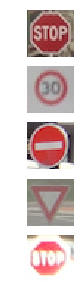

In [37]:
import os
import matplotlib.image as mpimg
import math
import numpy as np
import matplotlib.pyplot as plt


# test on own images
own_images_raw = np.array([mpimg.imread("own-images/" + imageName) for imageName in os.listdir("own-images")])
# own_images = np.array([cv2.convertScaleAbs(image) for image in own_images_raw])

count = len(own_images_raw)
fig, axs = plt.subplots(count, 1, figsize=(count, count))

print("Images picked from net are")

for i in range(count):        
    index = i
    image = own_images_raw[index]
    axs[i].imshow(image)
    axs[i].axis('off')
    #axs[i].set_title(label_mapping[y_train[index]])
    



### Manualy Sign Type for Each Image

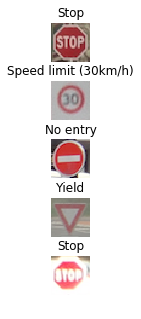

In [38]:
count = len(own_images_raw)
fig, axs = plt.subplots(count, 1, figsize=(count, count))
fig.subplots_adjust(hspace = .5, wspace=.001)
signType = [14,1,17,13,14]
for i in range(count):        
    index = i
    image = own_images_raw[index]
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(label_mapping[signType[index]])
    

### Analyze Performance

Accuracy on external images 60.0%
Images with softmax probabilities of top 5 predictions are


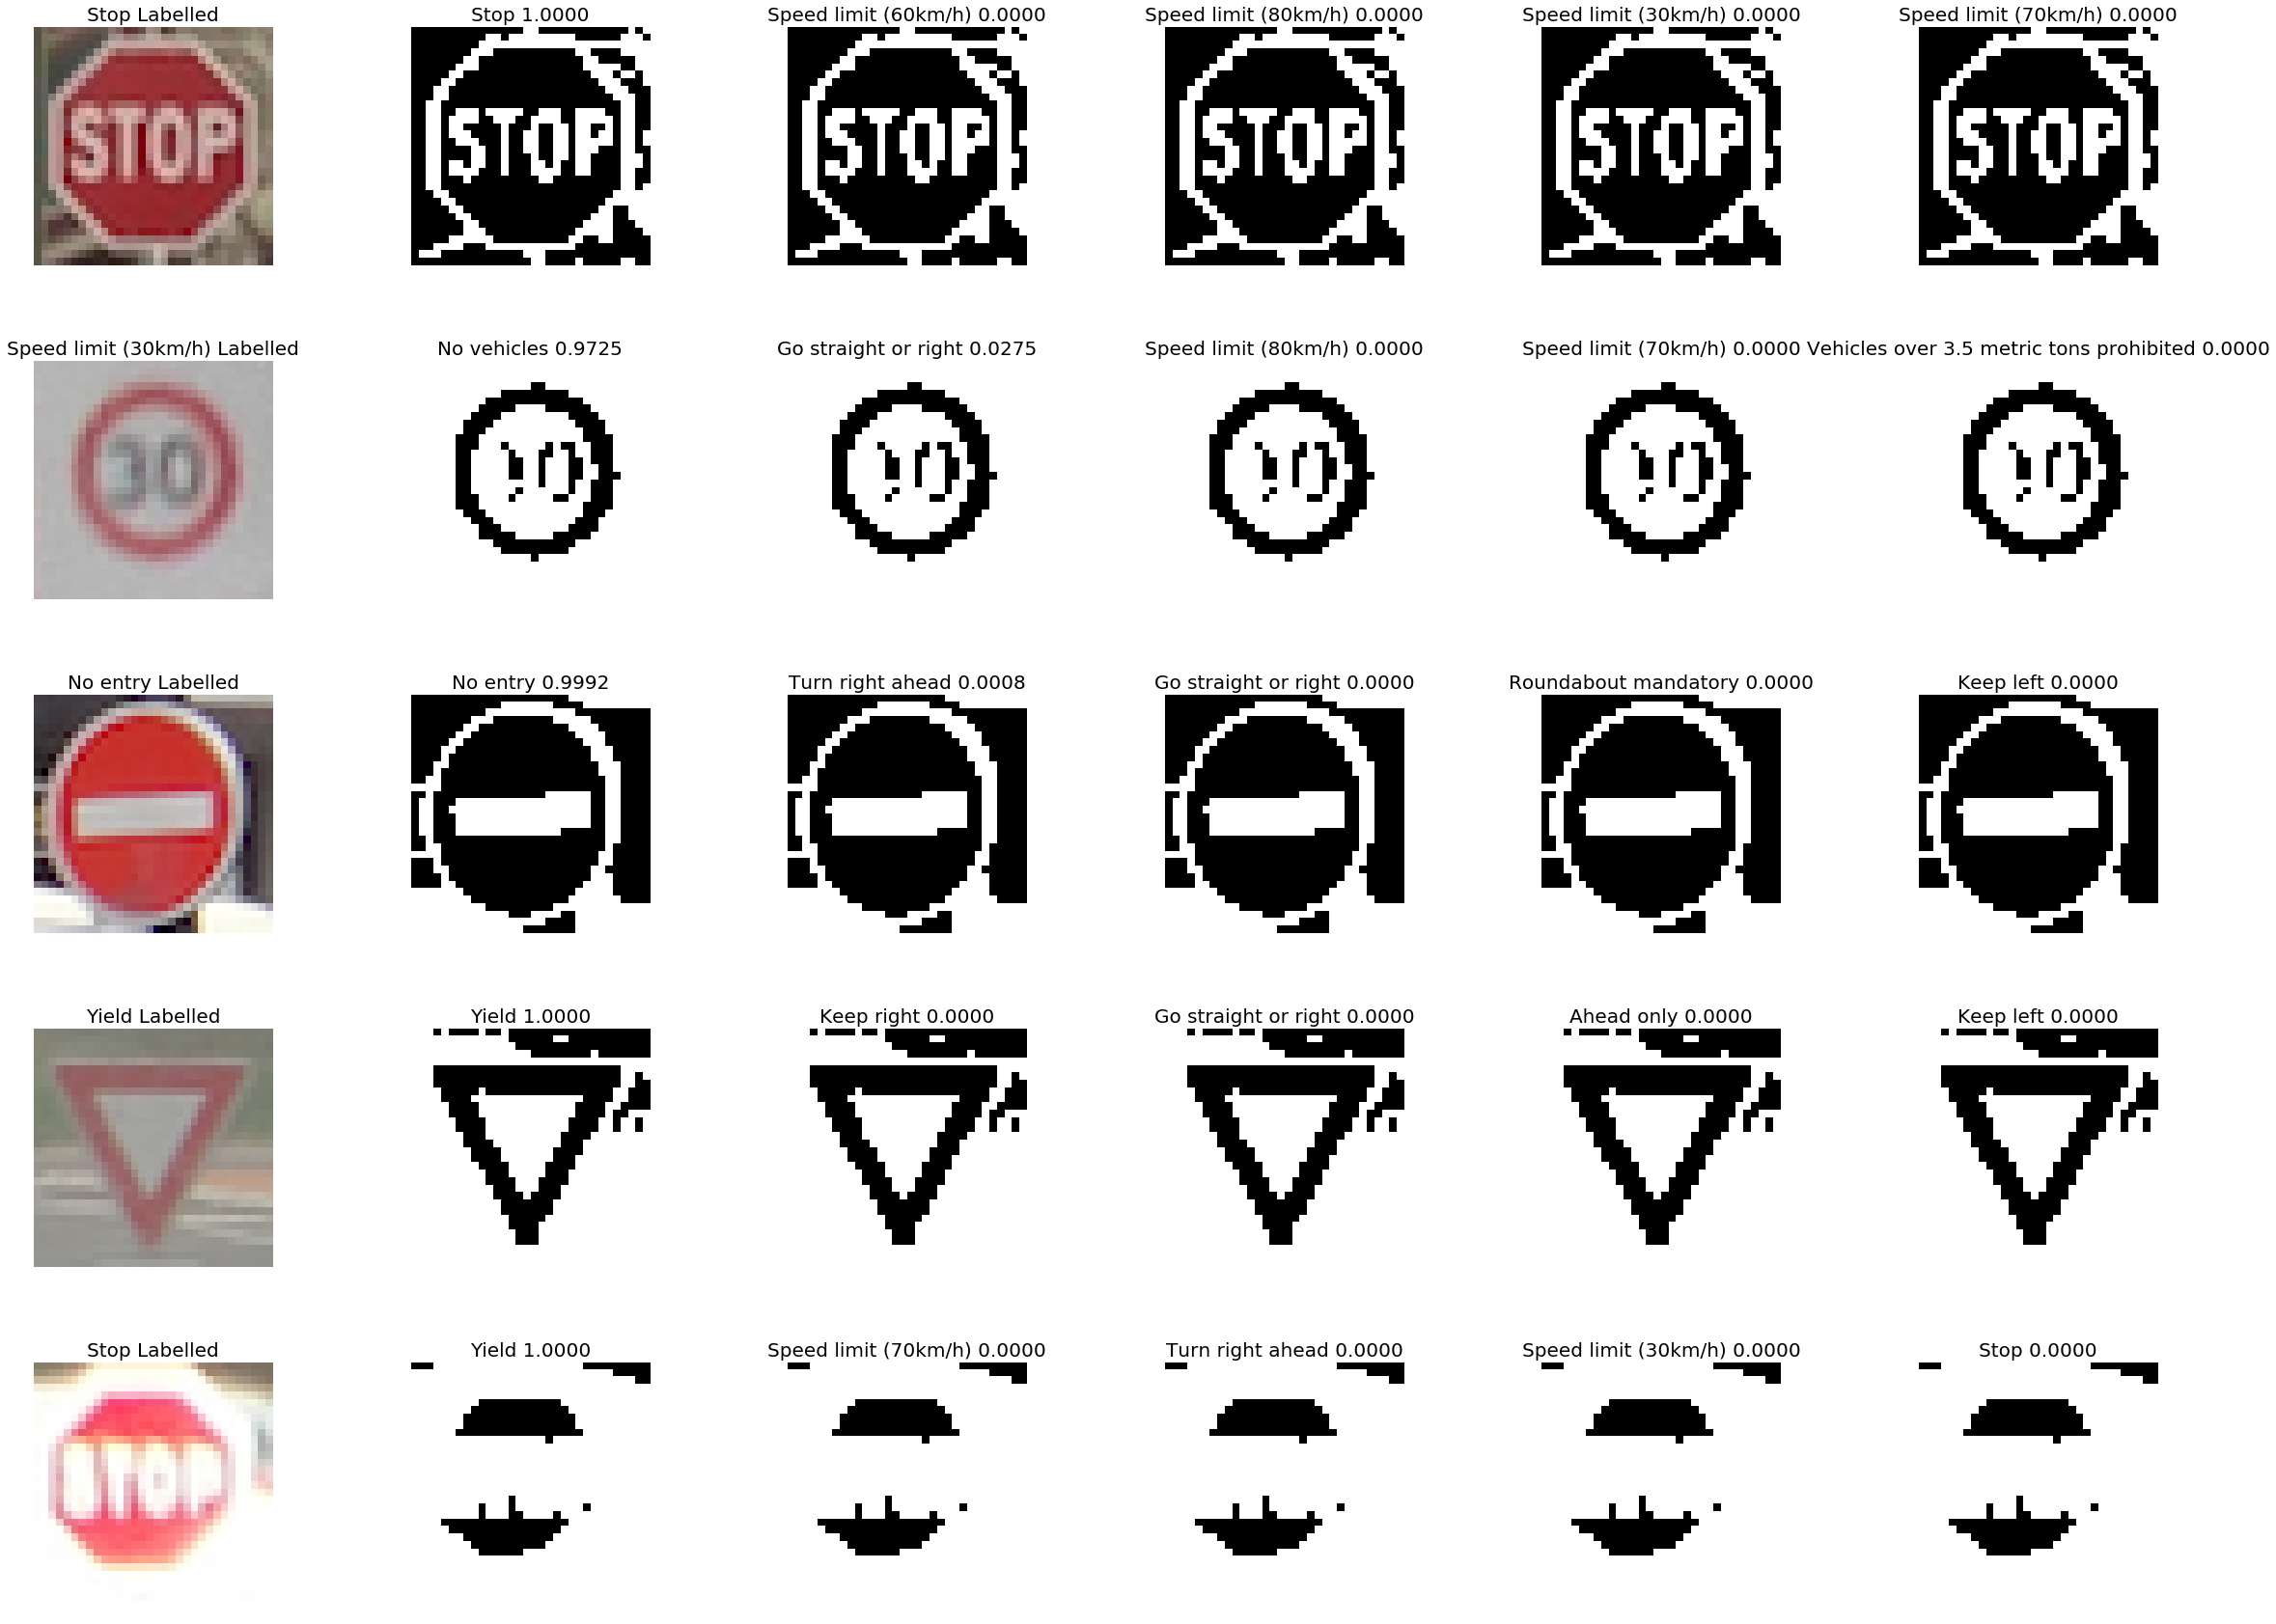

In [92]:
import math
import numpy

own_images = np.array([cv2.convertScaleAbs(image) for image in own_images_raw])
own_processed = numpy.array([process_image(image) for image in own_images])

# reshape for conv layer
own_reshaped = own_processed[..., newaxis]

# normalize range
own_normalized = own_reshaped - np.mean(own_reshaped)

#Softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    sample_out = sess.run(logits, feed_dict={x: own_normalized})
    top = sess.run(tf.nn.top_k(tf.constant(sample_out), k=1))
    top5 = sess.run(tf.nn.top_k(tf.constant(sample_out), k=5))
    
fig, axs = plt.subplots(count, 6, figsize=(count*8, count*6))
fig.subplots_adjust(hspace = 0.4, wspace=0.4)
accurate_images = 0
for i in range(count):
    softmax_score = softmax(sample_out[i])
    index = i 
    if(signType[index] == top5.indices[index][0] ):
        accurate_images = accurate_images + 1
    axs[i][0].imshow(own_images_raw[i])
    axs[i][0].axis('off')
    axs[i][0].set_title(label_mapping[signType[index]] + " Labelled",fontsize=20)
    
    axs[i][1].imshow(own_processed[i],cmap='gray')
    axs[i][1].axis('off')
    proab = "{0:.4f}".format(softmax_score[top5.indices[index][0]])
    axs[i][1].set_title(label_mapping[top5.indices[index][0]] +' '+ proab,fontsize=20)
    
    axs[i][2].imshow(own_processed[i],cmap='gray')
    axs[i][2].axis('off')
    proab = "{0:.4f}".format(softmax_score[top5.indices[index][1]])
    axs[i][2].set_title(label_mapping[top5.indices[index][1]] +' '+ proab,fontsize=20)
    
    axs[i][3].imshow(own_processed[i],cmap='gray')
    axs[i][3].axis('off')
    proab = "{0:.4f}".format(softmax_score[top5.indices[index][2]])
    axs[i][3].set_title(label_mapping[top5.indices[index][2]] +' '+ proab,fontsize=20)
    
    axs[i][4].imshow(own_processed[i],cmap='gray')
    axs[i][4].axis('off')
    proab = "{0:.4f}".format(softmax_score[top5.indices[index][3]])
    axs[i][4].set_title(label_mapping[top5.indices[index][3]] +' '+ proab,fontsize=20)
    
    axs[i][5].imshow(own_processed[i],cmap='gray')
    axs[i][5].axis('off')
    proab = "{0:.4f}".format(softmax_score[top5.indices[index][4]])
    axs[i][5].set_title(label_mapping[top5.indices[index][4]] +' '+ proab,fontsize=20)
    
    
    
print("Accuracy on external images " + str(accurate_images*100/count) + "%")
print("Images with softmax probabilities of top 5 predictions are")
    